# Import Libraries & Data

In [1]:
import pandas as pd
import numpy as np

import collections

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
directory = '../../data_PowerLaws_ForecastingEnergyConsumption/'

df_holidays = pd.read_csv(directory + 'holidays.csv', parse_dates=['Date'])
df_metadata = pd.read_csv(directory + 'metadata.csv')
df_submission_format = pd.read_csv(directory + 'submission_format.csv', parse_dates=['Timestamp'])
df_submission_frequency = pd.read_csv(directory + 'submission_frequency.csv')
df_train = pd.read_csv(directory + 'train.csv', parse_dates=['Timestamp'])
df_weather = pd.read_csv(directory + 'weather.csv', parse_dates=['Timestamp'])

In [3]:
# df_holidays drop unnecessary column
df_holidays = df_holidays.drop('Unnamed: 0', axis=1)

In [4]:
# df_metadata cast dtypes as int
df_metadata['MondayIsDayOff'] = df_metadata['MondayIsDayOff'].astype(int)
df_metadata['TuesdayIsDayOff'] = df_metadata['TuesdayIsDayOff'].astype(int)
df_metadata['WednesdayIsDayOff'] = df_metadata['WednesdayIsDayOff'].astype(int)
df_metadata['ThursdayIsDayOff'] = df_metadata['ThursdayIsDayOff'].astype(int)
df_metadata['FridayIsDayOff'] = df_metadata['FridayIsDayOff'].astype(int)
df_metadata['SaturdayIsDayOff'] = df_metadata['SaturdayIsDayOff'].astype(int)
df_metadata['SundayIsDayOff'] = df_metadata['SundayIsDayOff'].astype(int)

In [5]:
# there are three unique forecast time periods: 1440, 60, and 15 minutes
df_submission_frequency['ForecastPeriodMin'] = (df_submission_frequency['ForecastPeriodNS']
                                                .apply(lambda x: int(x / 60000000000)))

In [6]:
# df_weather drop unnecessary column
df_weather = df_weather.drop('Unnamed: 0', axis=1)

# Build ML DataFrame

**Steps to Creating ML DataFrame**

- Training data
    - Account for NaN (Interpolation)
- Merge
    - Meta data
    - Holidays
    - Weather
- Feature Engineering
    - Categorical Feature(s) Get Dummies for Holidays
    - Lagged features: t-1...

## [D] Create DataFrame

* FROM df_train

In [7]:
df_n_1 = df_train

In [8]:
# shape of df_n_1
shapes = collections.OrderedDict()
shapes['df_n_1'] = df_n_1.shape
for k,v in shapes.items(): 
    print("{}: \t {}".format(k,v))

df_n_1: 	 (6559830, 5)


In [9]:
# sort values, inspect... see NaN requires interpolation
df_n_1 = df_n_1.sort_values(['SiteId', 'ForecastId', 'Timestamp'], axis=0, ascending=[True,True,True])
df_n_1.head()

,obs_id,SiteId,Timestamp,ForecastId,Value
0,744519,1,2014-09-03,1,9.096555e+05
1,7627564,1,2014-09-04,1,1.748273e+06
2,7034705,1,2014-09-05,1,NaN
3,5995486,1,2014-09-06,1,NaN
4,7326510,1,2014-09-07,1,NaN


In [10]:
# 6,974 unique ForecastId's
df_n_1['ForecastId'].unique().size

6974

In [11]:
# 86,601 number of NaN values in training data set before interpolation
df_n_1['Value'].isnull().value_counts()

False    6473229
True       86601
Name: Value, dtype: int64

In [12]:
# 226 Number of SiteId with one or more single NaN values before interpolation
df_n_1[df_n_1['Value'].isnull()].groupby(['SiteId']).sum()['Value'].isnull().sum()

226

In [13]:
# 2,227 Number of ForecastId with one or more single NaN values before interpolation
df_n_1[df_n_1['Value'].isnull()].groupby(['ForecastId']).sum()['Value'].isnull().sum()

2227

In [14]:
# 90; 360; 964: unique number of data points per ForecastId in training data
df_n_1.groupby(['ForecastId'], as_index=False).agg({'Timestamp':'count'})['Timestamp'].unique()

array([360,  90, 964])

## [D] Add ForecastPeriodMin

* FROM df_submission_frequency

In [15]:
df_n_2 = df_n_1.copy(deep=True)

In [16]:
df_n_2 = df_n_2.merge(df_submission_frequency, on='ForecastId', how='inner')
df_n_2 = df_n_2.drop(['ForecastPeriodNS'], axis=1)
df_n_2.head()

,obs_id,SiteId,Timestamp,ForecastId,Value,ForecastPeriodMin
0,744519,1,2014-09-03,1,9.096555e+05,1440
1,7627564,1,2014-09-04,1,1.748273e+06,1440
2,7034705,1,2014-09-05,1,NaN,1440
3,5995486,1,2014-09-06,1,NaN,1440
4,7326510,1,2014-09-07,1,NaN,1440


In [17]:
# shape of df_n_2
shapes['df_n_2'] = df_n_2.shape
for k,v in shapes.items(): 
    print("{}: \t {}".format(k,v))

df_n_1: 	 (6559830, 5)
df_n_2: 	 (6559830, 6)


In [18]:
# ForecastPeriodMin value_counts by submission frequency
df_n_2['ForecastPeriodMin'].value_counts()

15      5248016
60      1258984
1440      52830
Name: ForecastPeriodMin, dtype: int64

## [D] Add df_metadata

In [19]:
df_n_3 = df_n_2.copy(deep=True)

In [20]:
df_metadata.head(2)

,SiteId,Surface,Sampling,BaseTemperature,MondayIsDayOff,TuesdayIsDayOff,WednesdayIsDayOff,ThursdayIsDayOff,FridayIsDayOff,SaturdayIsDayOff,SundayIsDayOff
0,1,1387.205119,15.0,18.0,0,0,0,0,0,1,1
1,2,6098.278376,30.0,18.0,0,0,0,0,0,1,1


In [21]:
df_metadata.shape

(267, 11)

### Add Surface and BaseTemperature

In [22]:
# merge Surface and BaseTemperature to ml dataframe
df_n_3 = df_n_3.merge(df_metadata[['SiteId', 'Surface', 'BaseTemperature']], on='SiteId', how='left')
df_n_3.head(2)

,obs_id,SiteId,Timestamp,ForecastId,Value,ForecastPeriodMin,Surface,BaseTemperature
0,744519,1,2014-09-03,1,9.096555e+05,1440,1387.205119,18.0
1,7627564,1,2014-09-04,1,1.748273e+06,1440,1387.205119,18.0


### Add isDayOff

In [23]:
# add Weekday to ml dataframe 
# first step is to create a dictionary of isDayOff using Weekday
df_n_3['Weekday'] = df_n_3['Timestamp'].dt.weekday
df_n_3.head(2)

,obs_id,SiteId,Timestamp,ForecastId,Value,ForecastPeriodMin,Surface,BaseTemperature,Weekday
0,744519,1,2014-09-03,1,9.096555e+05,1440,1387.205119,18.0,2
1,7627564,1,2014-09-04,1,1.748273e+06,1440,1387.205119,18.0,3


In [24]:
# create dict_metadata for efficient memory and search speed when applying isDayOff to dataframe
dict_metadata = {}

for index, row in df_metadata.iterrows():
    sid = row['SiteId'].astype(int)
    dict_metadata[sid, 0] = row['MondayIsDayOff'].astype(int)
    dict_metadata[sid, 1] = row['TuesdayIsDayOff'].astype(int)
    dict_metadata[sid, 2] = row['WednesdayIsDayOff'].astype(int)
    dict_metadata[sid, 3] = row['ThursdayIsDayOff'].astype(int)
    dict_metadata[sid, 4] = row['FridayIsDayOff'].astype(int)
    dict_metadata[sid, 5] = row['SaturdayIsDayOff'].astype(int)
    dict_metadata[sid, 6] = row['SundayIsDayOff'].astype(int)

In [25]:
# add isDayOff column to ml dataframe via apply lambda function referencing dict_metadata
df_n_3['isDayOff'] = df_n_3.apply(lambda row: dict_metadata[(row['SiteId'],row['Weekday'])], axis=1)
df_n_3 = df_n_3.drop('Weekday', axis=1)
df_n_3.head()

,obs_id,SiteId,Timestamp,ForecastId,Value,ForecastPeriodMin,Surface,BaseTemperature,isDayOff
0,744519,1,2014-09-03,1,9.096555e+05,1440,1387.205119,18.0,0
1,7627564,1,2014-09-04,1,1.748273e+06,1440,1387.205119,18.0,0
2,7034705,1,2014-09-05,1,NaN,1440,1387.205119,18.0,0
3,5995486,1,2014-09-06,1,NaN,1440,1387.205119,18.0,1
4,7326510,1,2014-09-07,1,NaN,1440,1387.205119,18.0,1


In [26]:
# shape of df_n_3
shapes['df_n_3'] = df_n_3.shape
for k,v in shapes.items(): 
    print("{}: \t {}".format(k,v))

df_n_1: 	 (6559830, 5)
df_n_2: 	 (6559830, 6)
df_n_3: 	 (6559830, 9)


## [D] Add df_holidays

In [27]:
df_n_4 = df_n_3.copy(deep=True)

In [28]:
# add a date column (without time) to merge on with df_holidays
df_n_4['Date'] = df_n_4['Timestamp'].apply(lambda x: x.date())

In [29]:
# create df_holidays_dates with boolean isHoliday for merging
df_holidays_dates = df_holidays[['SiteId', 'Date']].drop_duplicates()
df_holidays_dates['isHoliday'] = 1
df_holidays_dates['Date'] = df_holidays_dates['Date'].apply(lambda x: x.date())
df_holidays_dates.head()

,SiteId,Date,isHoliday
0,1,2016-01-01,1
1,1,2016-01-18,1
2,1,2016-02-15,1
3,1,2016-05-30,1
4,1,2016-07-04,1


In [30]:
# merge df_holidays_dates with dataframe
df_n_4 = df_n_4.merge(df_holidays_dates, on=['SiteId', 'Date'], how='left')
df_n_4 = df_n_4.drop('Date', axis=1)
df_n_4.head(2)

,obs_id,SiteId,Timestamp,ForecastId,Value,ForecastPeriodMin,Surface,BaseTemperature,isDayOff,isHoliday
0,744519,1,2014-09-03,1,9.096555e+05,1440,1387.205119,18.0,0,NaN
1,7627564,1,2014-09-04,1,1.748273e+06,1440,1387.205119,18.0,0,NaN


In [31]:
# fillna with 0... then make isHoliday an integer dtype
df_n_4['isHoliday'] = df_n_4['isHoliday'].fillna(value=0)
df_n_4['isHoliday'] = df_n_4['isHoliday'].astype(int)
df_n_4.head(2)

,obs_id,SiteId,Timestamp,ForecastId,Value,ForecastPeriodMin,Surface,BaseTemperature,isDayOff,isHoliday
0,744519,1,2014-09-03,1,9.096555e+05,1440,1387.205119,18.0,0,0
1,7627564,1,2014-09-04,1,1.748273e+06,1440,1387.205119,18.0,0,0


In [32]:
print("percent of days are Holidays: {}".format(round(df_n_4['isHoliday'].sum() / df_n_4['isHoliday'].count(),2)))

percent of days are Holidays: 0.02


In [33]:
# shape of df_n_4
shapes['df_n_4'] = df_n_4.shape
for k,v in shapes.items(): 
    print("{}: \t {}".format(k,v))

df_n_1: 	 (6559830, 5)
df_n_2: 	 (6559830, 6)
df_n_3: 	 (6559830, 9)
df_n_4: 	 (6559830, 10)


## Add df_weather

In [34]:
df_n_5 = df_n_4.copy(deep=True)

### Inspect df_weather

In [35]:
# inspect weather data
# see multiple Temperature for single SiteId & Timestamp combination
# need a single SiteId & Timestamp combination to merge with ml dataframe
df_weather.head()

,Timestamp,Temperature,Distance,SiteId
0,2013-12-31 19:00:00,-7.2,24.889929,1
1,2013-12-31 19:00:00,-8.3,23.303097,1
2,2013-12-31 19:00:00,-7.8,20.952256,1
3,2013-12-31 19:00:00,-8.0,20.952256,1
4,2013-12-31 19:34:00,-8.1,16.610602,1


In [36]:
# shape of weather data
df_weather.shape

(20017278, 4)

In [37]:
# remove extraneous SiteIds from df_weather not found in df_train
# shape of df_weather
df_weather = df_weather[df_weather['SiteId'].isin(pd.Series(df_n_5['SiteId'].unique()))]
df_weather.shape

(17563614, 4)

In [38]:
# check if all SiteIds in weather data are also found in the train data
# 52 fewer unique SiteIds in both weather data & train data than in train data alone (215 vs. 267)
# later, put these 52 SiteIds without weather data in separate ML DataFrame
df_weather['SiteId'].unique().size

215

### Keep Nearest Temperature

In [39]:
# example: view first 5 datapoints for SiteId 1
# see multiple Temperature for single SiteId & Timestamp combination
# need a single SiteId & Timestamp combination to merge with ml dataframe
df_weather[(df_weather['SiteId']==1)].head()

,Timestamp,Temperature,Distance,SiteId
0,2013-12-31 19:00:00,-7.2,24.889929,1
1,2013-12-31 19:00:00,-8.3,23.303097,1
2,2013-12-31 19:00:00,-7.8,20.952256,1
3,2013-12-31 19:00:00,-8.0,20.952256,1
4,2013-12-31 19:34:00,-8.1,16.610602,1


In [40]:
# create dataframe of nearest temperatures by SiteId and Timestamp
# inspect df_weather_nearest to compare above and see we took the nearest Temperature
df_weather_nearest = (df_weather.sort_values(['SiteId', 'Timestamp', 'Distance'])
                      .groupby(['SiteId', 'Timestamp'], as_index=False).first())
df_weather_nearest.head()

,SiteId,Timestamp,Temperature,Distance
0,1,2013-12-31 19:00:00,-7.8,20.952256
1,1,2013-12-31 19:34:00,-8.1,16.610602
2,1,2013-12-31 19:55:00,-8.2,16.610602
3,1,2013-12-31 20:00:00,-8.0,20.952256
4,1,2013-12-31 20:15:00,-8.3,16.610602


In [41]:
# df_weather_nearest shape
df_weather_nearest.shape

(11849490, 4)

In [42]:
# check if ther are NaN in Temperature... good, there are 0 NaN
df_weather_nearest.Temperature.isnull().sum()

0

### Resample Weather by 15min Intervals

In [43]:
def multi_index_resample(df, time_bins='15T'):

    df_list = []
    
    for i in df.index.unique():
        df_rs = df[df.index == i]
        df_rs = df_rs.reset_index().drop('SiteId', axis=1).set_index('Timestamp')
        df_rs = df_rs.resample(time_bins).interpolate(method='linear')
        df_rs = df_rs.reset_index()
        df_rs['SiteId'] = i
        df_list.append(df_rs)
    
    df_return = pd.concat(df_list, ignore_index=True)
    df_return = df_return[['SiteId', 'Timestamp', 'Temperature']]

    return df_return

In [44]:
# call multi_index_resample on df_weather_nearest
mask = ['SiteId', 'Timestamp', 'Temperature']
df_weather_nearest_resample15 = multi_index_resample(df_weather_nearest[mask].set_index('SiteId'))
df_weather_nearest_resample15.head()

,SiteId,Timestamp,Temperature
0,1,2013-12-31 19:00:00,-7.80
1,1,2013-12-31 19:15:00,-7.85
2,1,2013-12-31 19:30:00,-7.90
3,1,2013-12-31 19:45:00,-7.95
4,1,2013-12-31 20:00:00,-8.00


In [45]:
# Confirmed: 215 SiteIds in resampled weather data
df_weather_nearest_resample15.SiteId.unique().size

215

In [46]:
# shape of df_weather_nearest_resample15
df_weather_nearest_resample15.shape

(25130553, 3)

### Merge Resampled Weather Data

In [47]:
# merge average temperature by SiteId and Timestamp with dataframe
df_n_5 = df_n_5.merge(df_weather_nearest_resample15, on=['SiteId', 'Timestamp'], how='left')

In [48]:
# inspect dataframe
df_n_5.head(2)

,obs_id,SiteId,Timestamp,ForecastId,Value,ForecastPeriodMin,Surface,BaseTemperature,isDayOff,isHoliday,Temperature
0,744519,1,2014-09-03,1,9.096555e+05,1440,1387.205119,18.0,0,0,19.0
1,7627564,1,2014-09-04,1,1.748273e+06,1440,1387.205119,18.0,0,0,20.0


In [49]:
# shape of df_n_5
shapes['df_n_5'] = df_n_5.shape
for k,v in shapes.items(): 
    print("{}: \t {}".format(k,v))

df_n_1: 	 (6559830, 5)
df_n_2: 	 (6559830, 6)
df_n_3: 	 (6559830, 9)
df_n_4: 	 (6559830, 10)
df_n_5: 	 (6559830, 11)


### Inspect NaN temperatures

In [50]:
# 1,708,262 data points are missing temperature values
df_n_5['Temperature'].isnull().value_counts()

False    4851568
True     1708262
Name: Temperature, dtype: int64

In [51]:
# associated with 91 SiteId having 1 or more NaN Temperature values in training data
SiteId_with_null_temps = df_n_5[df_n_5['Temperature'].isnull()]['SiteId'].unique()
SiteId_with_null_temps.size

91

In [52]:
# associated with 1,832 ForecastId having 1 or more NaN Temperature values in training data
ForecastId_with_null_temps = df_n_5[df_n_5['Temperature'].isnull()]['ForecastId'].unique()
ForecastId_with_null_temps.size

1832

In [53]:
# inspect where dataframe temperature is null (i.e. no df_weather corresponding to df_train data)
# visual inspection shows most values for these SiteId's are NaN (where NaN=1)
# weather will not be a useable feature for these SiteIds... drop  
nrows = SiteId_with_null_temps.size
ncols = 1

#fig, ax = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(12,256), dpi=80, facecolor='w', edgecolor='k')
#for i in range(nrows):
#    sid = SiteId_with_null_temps[i]
#    section = df_n_5[df_n_5['SiteId']==sid]
#    ax[i].plot(section['Timestamp'], section['Temperature'].isnull().astype(int))
#    ax[i].set_title("SiteId: {}".format(sid));

#plt.tight_layout()

In [54]:
# now by calculations show % NaN weather values by SiteId
df_SiteId_with_null_temps = df_n_5[df_n_5['SiteId'].isin(SiteId_with_null_temps)].copy()
df_SiteId_with_null_temps['isNull_Temp'] = df_SiteId_with_null_temps['Temperature'].isnull()
df_null_temps = df_SiteId_with_null_temps.groupby('SiteId').agg({'isNull_Temp':['sum', 'count']})
df_null_temps['isNull_Temp', 'Percent_Null'] = (df_null_temps['isNull_Temp', 'sum'] 
                                                / df_null_temps['isNull_Temp', 'count'])
df_null_temps.head()

isNull_Temp                     
               sum   count Percent_Null
SiteId                                 
2             12.0   34704     0.000346
5             48.0     964     0.049793
6             48.0  140744     0.000341
11           964.0     964     1.000000
14         92544.0   92544     1.000000

In [55]:
# this shows that 79 of 91 SiteId's have 100% NaN weather values
# later, let's put these 79 SiteId's + 6 with high %_Null in separate Machine Learning dataframe
# inspect SiteId 180 & 93 for ForecastId's with weather data
# the bottom 6 SiteId's seems reasonable to keep because the % NaN < 5% which is low
# we can impute those values
df_null_temps.sort_values([('isNull_Temp', 'Percent_Null')], ascending=False).tail(15)

isNull_Temp                     
               sum   count Percent_Null
SiteId                                 
105          964.0     964     1.000000
90           450.0     450     1.000000
85           964.0     964     1.000000
17           892.0     900     0.991111
18           892.0     900     0.991111
157          608.0     900     0.675556
44           478.0     964     0.495851
180         5784.0   17352     0.333333
93          5784.0   21208     0.272727
5             48.0     964     0.049793
106          964.0   48200     0.020000
151          293.0   23136     0.012664
2             12.0   34704     0.000346
6             48.0  140744     0.000341
134            5.0   26992     0.000185

In [56]:
# 85 SiteId's with no weather data
keep_SiteId = list(df_null_temps[df_null_temps[('isNull_Temp', 'Percent_Null')] <= 0.05].index)
no_weather_SiteId = [s for s in SiteId_with_null_temps if s not in keep_SiteId]

len(no_weather_SiteId)

85

# Interpolate Values

In [57]:
df_n_6 = df_n_5.copy(deep=True)

## Inspect NaN Values (before interpolation)

In [58]:
# create dataframe to inspect the distribution of NaN Value across ForecastId
Nulls = df_n_6.groupby(['ForecastId']).apply(lambda row: row['Value'].isnull().sum())
Entries = df_n_6.groupby(['ForecastId']).apply(lambda row: row['Timestamp'].count())
df_NaN = pd.concat([Nulls, Entries], axis=1)
df_NaN.columns = ['Nulls', 'Entries']
df_NaN.head()

,Nulls,Entries
ForecastId,,
1,8,360
2,2,90
3,6,360
4,0,90
5,6,964


In [59]:
# merge with df_submission_frequency to chart by submission frequency
df_NaN = df_NaN.merge(df_submission_frequency, left_index=True, right_on='ForecastId')
df_NaN = df_NaN.drop('ForecastPeriodNS', axis=1)
df_NaN = df_NaN[['ForecastId', 'ForecastPeriodMin', 'Nulls', 'Entries']]
df_NaN['percent_NaN'] = df_NaN['Nulls'] / df_NaN['Entries']
df_NaN.head()

,ForecastId,ForecastPeriodMin,Nulls,Entries,percent_NaN
0,1,1440,8,360,0.022222
1,2,1440,2,90,0.022222
2,3,1440,6,360,0.016667
3,4,1440,0,90,0.000000
4,5,60,6,964,0.006224


In [60]:
df_NaN['percent_NaN'].describe()

count    6974.000000
mean        0.013120
std         0.068275
min         0.000000
25%         0.000000
50%         0.000000
75%         0.003112
max         1.000000
Name: percent_NaN, dtype: float64

In [61]:
df_NaN.sort_values('percent_NaN', ascending=False).head()

,ForecastId,ForecastPeriodMin,Nulls,Entries,percent_NaN
700,701,15,964,964,1.0
6067,6068,15,964,964,1.0
756,757,15,964,964,1.0
4491,4492,15,964,964,1.0
1398,1399,15,964,964,1.0


In [62]:
# if we just delete all NaN values, we delete rows 86,601 rows (~1% of data)
print("Potential to Remove \t Rows: {} \t Percent of Data: {}".format(df_NaN['Nulls'].sum(), round(df_NaN['Nulls'].sum() / df_NaN['Entries'].sum(), 2)))

Potential to Remove 	 Rows: 86601 	 Percent of Data: 0.01


In [63]:
# if we delete all Forecasts that contain one or more NaN Values, we delete 2,081,362 rows (~30% data)
print("Potential to Remove \t Rows: {} \t Percent of Data: {}".format(df_NaN[df_NaN['percent_NaN'] > 0].Entries.sum(), round(df_NaN[df_NaN['percent_NaN'] > 0].Entries.sum() / df_NaN['Entries'].sum(), 2)))

Potential to Remove 	 Rows: 2081362 	 Percent of Data: 0.32


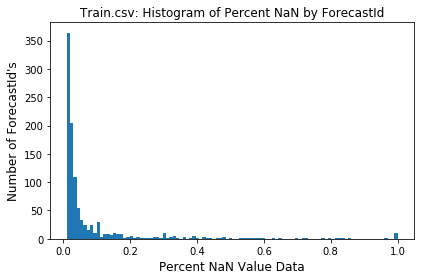

In [64]:
# histogram of ForecastId's with NaN values greater than 1% of series data
# takeaway: a lot of ForecastId's have a < 5% of missing data, while a few have more than 5%
fig = plt.figure(figsize=(6,4))
plt.hist(df_NaN[df_NaN['percent_NaN'] > 0.01]['percent_NaN'], bins=100)
plt.title("Train.csv: Histogram of Percent NaN by ForecastId", size=12)
plt.xlabel("Percent NaN Value Data", size=12)
plt.ylabel("Number of ForecastId's", size=12)
plt.tight_layout();
fig.savefig("EDA_hist_percent_NaNbyForecastId_greaterthan1percent.png")

## [D] Interpolate NaN Values

In [65]:
### VALIDATED - BUT ONLY WORKS MOVING FORWARD, NOT BACKFILL ###
### https://github.com/pandas-dev/pandas/issues/10420 ###

# add flag for "is_int"
df_n_6['Value_Int'] = df_n_6.groupby(['SiteId', 'ForecastId'])['Value'].apply(lambda x: x.interpolate(method='linear'))
df_n_6.head(10)

,obs_id,SiteId,Timestamp,ForecastId,Value,ForecastPeriodMin,Surface,BaseTemperature,isDayOff,isHoliday,Temperature,Value_Int
0,744519,1,2014-09-03,1,9.096555e+05,1440,1387.205119,18.0,0,0,19.0,9.096555e+05
1,7627564,1,2014-09-04,1,1.748273e+06,1440,1387.205119,18.0,0,0,20.0,1.748273e+06
2,7034705,1,2014-09-05,1,NaN,1440,1387.205119,18.0,0,0,22.0,1.802424e+06
3,5995486,1,2014-09-06,1,NaN,1440,1387.205119,18.0,1,0,21.0,1.856576e+06
4,7326510,1,2014-09-07,1,NaN,1440,1387.205119,18.0,1,0,13.0,1.910727e+06
5,3625268,1,2014-09-08,1,1.964878e+06,1440,1387.205119,18.0,0,0,12.0,1.964878e+06
6,6038546,1,2014-09-09,1,3.266904e+06,1440,1387.205119,18.0,0,0,17.0,3.266904e+06
7,4114748,1,2014-09-10,1,2.926094e+06,1440,1387.205119,18.0,0,0,17.0,2.926094e+06
8,2572804,1,2014-09-11,1,1.720502e+06,1440,1387.205119,18.0,0,0,23.0,1.720502e+06
9,2078763,1,2014-09-12,1,1.136248e+06,1440,1387.205119,18.0,0,0,12.0,1.136248e+06


In [66]:
# 25,480 number of NaN values in training data set after interpolation
df_n_6.Value_Int.isnull().value_counts()

False    6534350
True       25480
Name: Value_Int, dtype: int64

In [67]:
# 58 Number of SiteId with one or more single NaN values after interpolation
df_n_6[df_n_6.Value_Int.isnull()].groupby(['SiteId']).sum()['Value_Int'].isnull().sum()

58

In [68]:
# 104 Number of ForecastId with one or more single NaN values after interpolation
df_n_6[df_n_6['Value_Int'].isnull()].groupby(['ForecastId']).sum()['Value_Int'].isnull().sum()

104

### Inspect NaN Values (after interpolation)

In [69]:
# create dataframe to inspect the distribution of NaN Value across ForecastId
Nulls_2 = df_n_6.groupby(['ForecastId']).apply(lambda row: row['Value_Int'].isnull().sum())
Entries_2 = df_n_6.groupby(['ForecastId']).apply(lambda row: row['Timestamp'].count())
df_NaN_2 = pd.concat([Nulls_2, Entries_2], axis=1)
df_NaN_2.columns = ['Nulls', 'Entries']
df_NaN_2.head()

,Nulls,Entries
ForecastId,,
1,0,360
2,0,90
3,0,360
4,0,90
5,0,964


In [70]:
# merge with df_submission_frequency to chart by frequencies
df_NaN_2 = df_NaN_2.merge(df_submission_frequency, left_index=True, right_on='ForecastId')
df_NaN_2 = df_NaN_2.drop('ForecastPeriodNS', axis=1)
df_NaN_2 = df_NaN_2[['ForecastId', 'ForecastPeriodMin', 'Nulls', 'Entries']]
df_NaN_2['percent_NaN'] = df_NaN_2['Nulls'] / df_NaN_2['Entries']
df_NaN_2.head()

,ForecastId,ForecastPeriodMin,Nulls,Entries,percent_NaN
0,1,1440,0,360,0.0
1,2,1440,0,90,0.0
2,3,1440,0,360,0.0
3,4,1440,0,90,0.0
4,5,60,0,964,0.0


In [71]:
df_NaN_2['percent_NaN'].describe()

count    6974.000000
mean        0.003808
std         0.051750
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: percent_NaN, dtype: float64

In [72]:
df_NaN_2.sort_values('percent_NaN', ascending=False).tail()

,ForecastId,ForecastPeriodMin,Nulls,Entries,percent_NaN
2338,2339,15,0,964,0.0
2337,2338,15,0,964,0.0
2336,2337,15,0,964,0.0
2335,2336,15,0,964,0.0
6973,6974,15,0,964,0.0


In [73]:
# in the case of ForecastId == 1378, 2 NaN Value_Int remain after interpolation
df_n_6[df_n_6['ForecastId'] == 1378].loc[:,'Value_Int'].isnull().sum()

2

In [74]:
# in the case of ForecastId == 1378, these NaN Value_Int are located at beginning of data
# this is due to the linear interpolation algorithm which is range bound by data
df_n_6[df_n_6['ForecastId'] == 1378].head(5)

,obs_id,SiteId,Timestamp,ForecastId,Value,ForecastPeriodMin,Surface,BaseTemperature,isDayOff,isHoliday,Temperature,Value_Int
1296660,5949244,60,2016-03-09 01:30:00,1378,NaN,60,646.950606,18.0,0,0,NaN,NaN
1296661,4987235,60,2016-03-09 02:30:00,1378,NaN,60,646.950606,18.0,0,0,NaN,NaN
1296662,1715606,60,2016-03-09 03:30:00,1378,9567.609451,60,646.950606,18.0,0,0,NaN,9567.609451
1296663,2768547,60,2016-03-09 04:30:00,1378,9483.626864,60,646.950606,18.0,0,0,NaN,9483.626864
1296664,1940139,60,2016-03-09 05:30:00,1378,9748.385528,60,646.950606,18.0,0,0,NaN,9748.385528


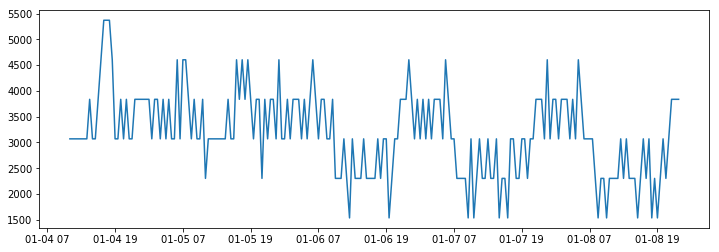

In [75]:
# Ex: ForecastId 608 starts 12/28 but NaN through 01/04 06

x1 = df_n_6[df_n_6['ForecastId'] == 608]['Timestamp']
y1 = df_n_6[df_n_6['ForecastId'] == 608]['Value']

plt.figure(figsize=(12,4))
plt.plot(x1, y1);

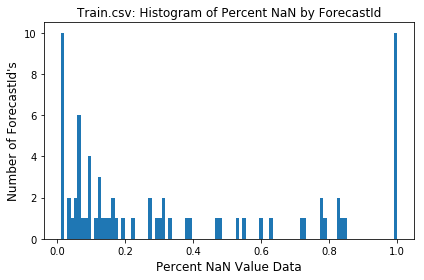

In [76]:
# Histogram of ForecastId's with NaN values greater than 1% of series data

fig = plt.figure(figsize=(6,4))
plt.hist(df_NaN_2[df_NaN_2['percent_NaN'] > 0.01]['percent_NaN'], bins=100)
plt.title("Train.csv: Histogram of Percent NaN by ForecastId", size=12)
plt.xlabel("Percent NaN Value Data", size=12)
plt.ylabel("Number of ForecastId's", size=12)
plt.tight_layout();
fig.savefig("EDA_hist_percent_NaNbyForecastId_2_greaterthan1percent.png")

In [77]:
# if we just delete all NaN values, we delete rows 25,480 rows (~0% of data)
print("Potential to Remove \t Rows: {} \t Percent of Data: {}".format(df_NaN_2['Nulls'].sum(), round(df_NaN_2['Nulls'].sum() / df_NaN_2['Entries'].sum(), 2)))

Potential to Remove 	 Rows: 25480 	 Percent of Data: 0.0


In [78]:
# if we delete all Forecasts that contain one or more NaN Values, we delete 96,426 rows (~1% data)
print("Potential to Remove \t Rows: {} \t Percent of Data: {}".format(df_NaN_2[df_NaN_2['percent_NaN'] > 0].Entries.sum(), round(df_NaN_2[df_NaN_2['percent_NaN'] > 0].Entries.sum() / df_NaN_2['Entries'].sum(), 2)))

Potential to Remove 	 Rows: 96426 	 Percent of Data: 0.01


# [D] Add Lagged Features

In [79]:
df_n_7 = df_n_6.copy(deep=True)

In [80]:
# Add lagged feature(s)
df_n_7['Value_Lag_1'] = df_n_7.groupby(['SiteId', 'ForecastId'])['Value_Int'].shift(1)
df_n_7['Value_Lag_2'] = df_n_7.groupby(['SiteId', 'ForecastId'])['Value_Int'].shift(2)
df_n_7['Value_Lag_3'] = df_n_7.groupby(['SiteId', 'ForecastId'])['Value_Int'].shift(3)
df_n_7['Value_Lag_4'] = df_n_7.groupby(['SiteId', 'ForecastId'])['Value_Int'].shift(4)
df_n_7.head()

,obs_id,SiteId,Timestamp,ForecastId,Value,ForecastPeriodMin,Surface,BaseTemperature,isDayOff,isHoliday,Temperature,Value_Int,Value_Lag_1,Value_Lag_2,Value_Lag_3,Value_Lag_4
0,744519,1,2014-09-03,1,9.096555e+05,1440,1387.205119,18.0,0,0,19.0,9.096555e+05,NaN,NaN,NaN,NaN
1,7627564,1,2014-09-04,1,1.748273e+06,1440,1387.205119,18.0,0,0,20.0,1.748273e+06,9.096555e+05,NaN,NaN,NaN
2,7034705,1,2014-09-05,1,NaN,1440,1387.205119,18.0,0,0,22.0,1.802424e+06,1.748273e+06,9.096555e+05,NaN,NaN
3,5995486,1,2014-09-06,1,NaN,1440,1387.205119,18.0,1,0,21.0,1.856576e+06,1.802424e+06,1.748273e+06,9.096555e+05,NaN
4,7326510,1,2014-09-07,1,NaN,1440,1387.205119,18.0,1,0,13.0,1.910727e+06,1.856576e+06,1.802424e+06,1.748273e+06,909655.510515


In [81]:
# shape of df_n_7
shapes['df_n_7'] = df_n_7.shape
for k,v in shapes.items(): 
    print("{}: \t {}".format(k,v))

df_n_1: 	 (6559830, 5)
df_n_2: 	 (6559830, 6)
df_n_3: 	 (6559830, 9)
df_n_4: 	 (6559830, 10)
df_n_5: 	 (6559830, 11)
df_n_7: 	 (6559830, 16)


# Feature Engineering

In [82]:
df_n_8 = df_n_7.copy(deep=True)

In [83]:
df_n_8.head(2)

,obs_id,SiteId,Timestamp,ForecastId,Value,ForecastPeriodMin,Surface,BaseTemperature,isDayOff,isHoliday,Temperature,Value_Int,Value_Lag_1,Value_Lag_2,Value_Lag_3,Value_Lag_4
0,744519,1,2014-09-03,1,9.096555e+05,1440,1387.205119,18.0,0,0,19.0,9.096555e+05,NaN,NaN,NaN,NaN
1,7627564,1,2014-09-04,1,1.748273e+06,1440,1387.205119,18.0,0,0,20.0,1.748273e+06,909655.510515,NaN,NaN,NaN


## Temperature Features

In [84]:
# add difference of (outside) Temperature to BaseTemperature
df_n_8['Temp_Minus_BaseTemp'] = df_n_8['Temperature'] - df_n_8['BaseTemperature']
df_n_8['Temp_Div_BaseTemp'] = df_n_8['Temperature'] / df_n_8['BaseTemperature']
df_n_8.head(2)

,obs_id,SiteId,Timestamp,ForecastId,Value,ForecastPeriodMin,Surface,BaseTemperature,isDayOff,isHoliday,Temperature,Value_Int,Value_Lag_1,Value_Lag_2,Value_Lag_3,Value_Lag_4,Temp_Minus_BaseTemp,Temp_Div_BaseTemp
0,744519,1,2014-09-03,1,9.096555e+05,1440,1387.205119,18.0,0,0,19.0,9.096555e+05,NaN,NaN,NaN,NaN,1.0,1.055556
1,7627564,1,2014-09-04,1,1.748273e+06,1440,1387.205119,18.0,0,0,20.0,1.748273e+06,909655.510515,NaN,NaN,NaN,2.0,1.111111


## Add Month & Quarter Features

In [85]:
# add month features to ml dataframe
df_n_8['Month'] = df_n_8['Timestamp'].dt.month
df_n_8[['Month_1', 'Month_2', 'Month_3','Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', \
        'Month_9', 'Month_10', 'Month_11', 'Month_12']] = pd.get_dummies(df_n_8['Month'])
df_n_8 = df_n_8.drop('Month', axis=1)
df_n_8.head(2)

,obs_id,SiteId,Timestamp,ForecastId,Value,ForecastPeriodMin,Surface,BaseTemperature,isDayOff,isHoliday,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,744519,1,2014-09-03,1,9.096555e+05,1440,1387.205119,18.0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,7627564,1,2014-09-04,1,1.748273e+06,1440,1387.205119,18.0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [86]:
# add quarter features to ml dataframe
df_n_8['Quarter'] = df_n_8['Timestamp'].dt.quarter
df_n_8[['Quarter_1', 'Quarter_2', 'Quarter_3','Quarter_4']] = pd.get_dummies(df_n_8['Quarter'])
df_n_8 = df_n_8.drop('Quarter', axis=1)
df_n_8.head(2)

,obs_id,SiteId,Timestamp,ForecastId,Value,ForecastPeriodMin,Surface,BaseTemperature,isDayOff,isHoliday,...,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Quarter_1,Quarter_2,Quarter_3,Quarter_4
0,744519,1,2014-09-03,1,9.096555e+05,1440,1387.205119,18.0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,7627564,1,2014-09-04,1,1.748273e+06,1440,1387.205119,18.0,0,0,...,0,0,1,0,0,0,0,0,1,0


# Pickle ML DataFrame 

## Inspect Final DataFrame

In [87]:
df_n_8.head(2)

,obs_id,SiteId,Timestamp,ForecastId,Value,ForecastPeriodMin,Surface,BaseTemperature,isDayOff,isHoliday,...,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Quarter_1,Quarter_2,Quarter_3,Quarter_4
0,744519,1,2014-09-03,1,9.096555e+05,1440,1387.205119,18.0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,7627564,1,2014-09-04,1,1.748273e+06,1440,1387.205119,18.0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [88]:
# shape of df_n_8
shapes['df_n_8'] = df_n_8.shape
for k,v in shapes.items(): 
    print("{}: \t {}".format(k,v))

df_n_1: 	 (6559830, 5)
df_n_2: 	 (6559830, 6)
df_n_3: 	 (6559830, 9)
df_n_4: 	 (6559830, 10)
df_n_5: 	 (6559830, 11)
df_n_7: 	 (6559830, 16)
df_n_8: 	 (6559830, 34)


## Pickle DataFrame

In [89]:
df_n_8.to_csv(directory + 'df_n_8.csv')

# df_n_8.to_pickle('df_n_8.pkl')
#df_n_7[~df_n_7['SiteId'].isin(no_weather_SiteId)].to_pickle('mldataframe.pkl')
#df_n_7[df_n_7['SiteId'].isin(no_weather_SiteId)].to_pickle('mldataframe_noweather.pkl')

# Regression DataFrame

In [124]:
df_n_9 = df_n_8.copy(deep=True)

In [125]:
#df_sparse_n_9 = pd.SparseDataFrame(df_n_9)
#df_sparse_n_9.head(2)

## SiteId Sparse Features

In [126]:
df_sid_dummies = pd.get_dummies(df_n_9['SiteId'])
df_sid_dummies.shape

#df_sparse_sid_dummies = pd.SparseDataFrame(df_sid_dummies)
#df_sparse_sid_dummies.shape

(6559830, 267)

In [127]:
col_names = []

for c_name in df_sid_dummies.columns:
    col_names.append("SiteId_" + str(c_name))

df_sid_dummies.columns = col_names

In [128]:
df_n_9 = df_n_9.merge(df_sid_dummies, left_index=True, right_index=True, how='left')

## Time of Day Sparse Features

In [129]:
# Note: not all measurements start at 00:00 hr:min... some are offset.
# this function myround shifts the minutes on the same 0,15,30,45 times for easy comparison
# all data points are taken at 15min, 60min, or daily intervals so this works
# worst case is being off by a rounding error of 7.5min which is insignificant

def round_min(x, base=15):
    return int(base * round(float(x)/base))

df_n_9['Hour'] = df_n_9['Timestamp'].dt.hour.astype(str)
df_n_9['Minute_rd15'] = df_n_9['Timestamp'].dt.minute.map(round_min).astype(str)

In [130]:
df_n_9['Hour'].unique()

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'],
      dtype=object)

In [131]:
# need to account for 60min == 00min + 1hr
df_n_9['Minute_rd15'].unique()

array(['0', '15', '30', '45', '60'], dtype=object)

In [132]:
df_n_9['Hour_Min'] = df_n_9['Hour'] + "_" + df_n_9['Minute_rd15']

In [133]:
# before mapping round_hour to Hour_Min we have many hr:60 min which should be hr+1:00 min
df_n_9['Hour_Min'].unique()

array(['0_0', '1_0', '2_0', '3_0', '4_0', '5_0', '6_0', '7_0', '8_0',
       '9_0', '10_0', '11_0', '12_0', '13_0', '14_0', '15_0', '16_0',
       '17_0', '18_0', '19_0', '20_0', '21_0', '22_0', '23_0', '1_15',
       '1_30', '1_45', '2_15', '2_30', '2_45', '3_15', '3_30', '3_45',
       '4_15', '4_30', '4_45', '5_15', '5_30', '5_45', '6_15', '6_30',
       '6_45', '7_15', '7_30', '7_45', '8_15', '8_30', '8_45', '9_15',
       '9_30', '9_45', '10_15', '10_30', '10_45', '11_15', '11_30',
       '11_45', '12_15', '12_30', '12_45', '13_15', '13_30', '13_45',
       '14_15', '14_30', '14_45', '15_15', '15_30', '15_45', '16_15',
       '16_30', '16_45', '17_15', '17_30', '17_45', '18_15', '18_30',
       '18_45', '19_15', '19_30', '19_45', '20_15', '20_30', '20_45',
       '21_15', '21_30', '21_45', '22_15', '22_30', '22_45', '23_15',
       '23_30', '23_45', '0_15', '0_30', '0_45', '12_60', '13_60',
       '14_60', '15_60', '16_60', '17_60', '18_60', '19_60', '20_60',
       '21_60', '22_6

In [134]:
def round_hour(x, base=60):
    hour = x.split('_')[0]
    minute = x.split('_')[1]
    if (minute == '60') and (hour == '23'):
        return '0_0'
    elif (minute == '60') and (hour != '23'):
        hour = str(int(hour) + 1)
        minute = '0'
        return hour + '_' + minute
    else:
        return x

In [135]:
df_n_9['Hour_Min'] = df_n_9['Hour_Min'].map(round_hour)

In [136]:
df_n_9['Hour_Min'].unique()

array(['0_0', '1_0', '2_0', '3_0', '4_0', '5_0', '6_0', '7_0', '8_0',
       '9_0', '10_0', '11_0', '12_0', '13_0', '14_0', '15_0', '16_0',
       '17_0', '18_0', '19_0', '20_0', '21_0', '22_0', '23_0', '1_15',
       '1_30', '1_45', '2_15', '2_30', '2_45', '3_15', '3_30', '3_45',
       '4_15', '4_30', '4_45', '5_15', '5_30', '5_45', '6_15', '6_30',
       '6_45', '7_15', '7_30', '7_45', '8_15', '8_30', '8_45', '9_15',
       '9_30', '9_45', '10_15', '10_30', '10_45', '11_15', '11_30',
       '11_45', '12_15', '12_30', '12_45', '13_15', '13_30', '13_45',
       '14_15', '14_30', '14_45', '15_15', '15_30', '15_45', '16_15',
       '16_30', '16_45', '17_15', '17_30', '17_45', '18_15', '18_30',
       '18_45', '19_15', '19_30', '19_45', '20_15', '20_30', '20_45',
       '21_15', '21_30', '21_45', '22_15', '22_30', '22_45', '23_15',
       '23_30', '23_45', '0_15', '0_30', '0_45'], dtype=object)

In [137]:
df_hm_dummies = pd.get_dummies(df_n_9['Hour_Min'])
df_hm_dummies.shape

# df_sparse_hm_dummies = pd.SparseDataFrame(df_hm_dummies)
# df_sparse_hm_dummies.shape

(6559830, 96)

In [139]:
col_names = []

for c_name in df_hm_dummies.columns:
    col_names.append("Hour_Min_" + str(c_name))

df_hm_dummies.columns = col_names

In [141]:
df_n_9 = df_n_9.merge(df_hm_dummies, left_index=True, right_index=True, how='left')
df_n_9.shape

# df_sparse_n_9 = df_sparse_n_9.merge(df_sparse_hm_dummies, left_index=True, right_index=True, how='left')
# df_sparse_n_9.shape

(6559830, 400)

In [142]:
df_n_9.head(2)
# df_sparse_n_9.head(2)

,obs_id,SiteId,Timestamp,ForecastId,Value,ForecastPeriodMin,Surface,BaseTemperature,isDayOff,isHoliday,...,Hour_Min_7_30,Hour_Min_7_45,Hour_Min_8_0,Hour_Min_8_15,Hour_Min_8_30,Hour_Min_8_45,Hour_Min_9_0,Hour_Min_9_15,Hour_Min_9_30,Hour_Min_9_45
0,744519,1,2014-09-03,1,9.096555e+05,1440,1387.205119,18.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7627564,1,2014-09-04,1,1.748273e+06,1440,1387.205119,18.0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Pickle Sparse DataFrame

In [101]:
# df_sparse_n_9 = pd.SparseDataFrame(df_n_9)

In [143]:
# create (or open) an hdf5 file and opens in append mode
# hdf = pd.HDFStore(directory + 'df_n_9.h5')

# put the dataset in the storage
# hdf.put('df_n_9', df_n_9, format='table', data_columns=True)

df_n_9.to_csv(directory + 'df_n_9.csv')
#df_n_9.to_pickle('df_n_9.pkl')

# Prepare Submission Set

# Baseline Forecasts

* Note: where ML forecast is incomplete fill-in forecast values with the best available Baseline Forecast

In [144]:
# predict average 15min energy consumption by ForecastId
df_submission_format.head(2)

,obs_id,SiteId,Timestamp,ForecastId,Value
0,1677832,1,2015-08-29,1,0.0
1,5379616,1,2015-08-30,1,0.0


In [145]:
df_submission_format.shape

(1309176, 5)

In [146]:
df_train.head(2)

,obs_id,SiteId,Timestamp,ForecastId,Value
0,744519,1,2014-09-03,1,9.096555e+05
1,7627564,1,2014-09-04,1,1.748273e+06


## Submission_1

* forecast a single average value of training data for each ForecastId
* fillna(0)

In [147]:
df_train_avg_forecastid = (df_train.groupby(['ForecastId'], as_index=False).agg({'Value':'mean'}))
df_train_avg_forecastid.head()

,ForecastId,Value
0,1,4.463354e+06
1,2,5.869653e+06
2,3,3.683968e+06
3,4,5.682236e+06
4,5,8.768727e+04


In [148]:
df_submission_1 = df_submission_format.merge(df_train_avg_forecastid, on='ForecastId', how='left')
df_submission_1.head(2)

,obs_id,SiteId,Timestamp,ForecastId,Value_x,Value_y
0,1677832,1,2015-08-29,1,0.0,4.463354e+06
1,5379616,1,2015-08-30,1,0.0,4.463354e+06


In [149]:
df_submission_1 = df_submission_1.drop('Value_x', axis=1)
df_submission_1 = df_submission_1.rename(columns={'Value_y':'Value'})
df_submission_1.head(2)

,obs_id,SiteId,Timestamp,ForecastId,Value
0,1677832,1,2015-08-29,1,4.463354e+06
1,5379616,1,2015-08-30,1,4.463354e+06


In [150]:
df_submission_1.shape

(1309176, 5)

In [151]:
# 1,920 NaN Values
df_submission_1['Value'].isnull().sum()

1920

In [152]:
# fillna with 0
df_submission_1['Value'] = df_submission_1['Value'].fillna(value=0)

In [153]:
# 0 NaN Values
df_submission_1.Value.isnull().sum()

0

In [154]:
# set index to obs_id to match submission format
df_submission_1 = df_submission_1.set_index('obs_id')
df_submission_1.head(2)

,SiteId,Timestamp,ForecastId,Value
obs_id,,,,
1677832,1,2015-08-29,1,4.463354e+06
5379616,1,2015-08-30,1,4.463354e+06


In [155]:
# create submission_1.csv
# drivendata : 0.007459
df_submission_1.to_csv(directory + 'submission_1.csv')

## Submission_2

* forecast the average hour:minute energy consumption for each ForecastId 
    * (i.e. 96 points per 15min interval submission frequency)
    * (i.e. 24 points per 60min interval submission frequency)
    * (i.e.  1 point per 1140min interval submission frequency (same result as submission_1))
* fillna(0)

In [ ]:
# create df_train_2 with hour:min data
df_train_2 = df_train.copy(deep=True)
df_train_2['Hour'] = df_train_2['Timestamp'].dt.hour
df_train_2['Minute'] = df_train_2['Timestamp'].dt.minute
df_train_2.head(2)

In [ ]:
# get average value per time submission frequency by ForecastId
df_train_avg_forecastid_hourmin = (df_train_2.groupby(['ForecastId','Hour','Minute'], as_index=False).agg({'Value':'mean'}))
df_train_avg_forecastid_hourmin.head()

In [ ]:
df_train_avg_forecastid_hourmin.shape

In [ ]:
# create df_submission_format_2 with hour:min data
df_submission_format_2 = df_submission_format.copy(deep=True)
df_submission_format_2['Timestamp'] = pd.to_datetime(df_submission_format_2['Timestamp'])
df_submission_format_2['Hour'] = df_submission_format_2['Timestamp'].dt.hour
df_submission_format_2['Minute'] = df_submission_format_2['Timestamp'].dt.minute
df_submission_format_2.head(2)

In [ ]:
df_submission_2 = df_submission_format_2.merge(df_train_avg_forecastid_hourmin, on=['ForecastId','Hour','Minute'], how='left')
df_submission_2.head(2)

In [ ]:
df_submission_2 = df_submission_2.drop(['Value_x', 'Hour', 'Minute'], axis=1)
df_submission_2 = df_submission_2.rename(columns={'Value_y':'Value'})
df_submission_2.head(2)

In [ ]:
df_submission_2.shape

In [ ]:
# 2,482 NaN Values
df_submission_2['Value'].isnull().sum()

In [ ]:
# fillna with 0
df_submission_2['Value'] = df_submission_2['Value'].fillna(value=0)

In [ ]:
# 0 NaN Values
df_submission_2['Value'].isnull().sum()

In [ ]:
# set index to obs_id to match submission format
df_submission_2 = df_submission_2.set_index('obs_id')
df_submission_2.head(2)

In [ ]:
# create submission_2.csv
# drivendata score: 0.005652
# df_submission_2.to_csv(directory + 'submission_2.csv')

## df_submission_3

* create a distribution of daily energy consumption for various SiteId's
* make two distributions: 1. non-holiday / non-off-day, 2. holiday or off-day
* then add a multiplier to the distributions based upon the season of year
    * (i.e. 96 points per 15min interval submission frequency)
    * (i.e. 24 points per 60min interval submission frequency)
    * (i.e.  1 point per 1140min interval submission frequency (same result as submission_1))
* fillna(0)

In [ ]:
df_n_8.head(1)

In [ ]:
# create df_n_submission_3 with hour:min data
df_n_submission_3 = df_n_8.copy(deep=True)
df_n_submission_3['Hour'] = df_n_submission_3['Timestamp'].dt.hour
df_n_submission_3['Minute'] = df_n_submission_3['Timestamp'].dt.minute
df_n_submission_3.head(2)

In [ ]:
drop_columns = ['Value', 'Value_Lag_1', 'Value_Lag_2', 'Value_Lag_3', 'Value_Lag_4', 'Temp_Minus_BaseTemp',]
df_n_submission_3 = df_n_submission_3.drop(drop_columns, axis=1)
df_n_submission_3.head(2)

In [ ]:
df_n_submission_3['isDayOffOrHoliday'] = (df_n_submission_3['isDayOff'] + df_n_submission_3['isHoliday']) > 0
df_n_submission_3['isDayOffOrHoliday'] = df_n_submission_3['isDayOffOrHoliday'].astype(int)
df_n_submission_3.head(2)

In [ ]:
# get average value per time submission frequency by ForecastId
mask = (df_n_submission_3['ForecastPeriodMin'] == 15)
df_s_3_split_avg_forecastid_hourmin_15 = (df_n_submission_3[mask].groupby(['SiteId','isDayOff','Hour','Minute'], as_index=False).agg({'Value_Int':'mean'}))
df_s_3_split_avg_forecastid_hourmin_15.head()

In [ ]:
# these are the SiteId that have ForecastPeriodMin == 15
sid_fpm_15 = df_s_3_split_avg_forecastid_hourmin_15['SiteId'].unique()
sid_fpm_15

In [ ]:
sid = 41
mask = (df_s_3_split_avg_forecastid_hourmin['SiteId'] == sid) & (df_s_3_split_avg_forecastid_hourmin['isDayOff'] == 0)
df_s_3_split_avg_forecastid_hourmin[mask]['Value_Int'].plot()

mask = (df_s_3_split_avg_forecastid_hourmin['SiteId'] == sid) & (df_s_3_split_avg_forecastid_hourmin['isDayOff'] == 1)
df_s_3_split_avg_forecastid_hourmin[mask]['Value_Int'].plot()

# TO DO
* timeseries tutorial analytics vidhya
* start the presentation: create appendix EDA slides

**Today's Goals**
* Time Series as Index
* Fill NaN / Ignore in train data
* Understand train vs. submission time periods
    * Use Forecast values as inputs for future forecasts
* feature engineering for temp v. surface area v. ppl in building (stand in is vacation days)
* 
    